# Working with MEG dataset
MEG dataset from THINGS initiative: https://openneuro.org/datasets/ds004212/versions/2.0.1
### Training data partition
The data is .fif file which needs to be converted into a rather easy to use .npy array.
We will use mne library for this: https://mne.tools/dev/index.html 


We collected extensively sampled object representations using magnetoencephalography (MEG). To this end, we drew on the THINGS database (Hebart et al., 2019), a richly-annotated database of 1,854 object concepts representative of the American English language which contains 26,107 manually-curated naturalistic object images.

ERP = event-related potential; signal with respect to some event
VEP = ERP for visual stimuli



27084 events, 281 time points, 271 channels

## Here we perform NMF experiements. And data matrix as concepts x channes*time

## Comparing results for different participants
Functions have been moved out of the class object.



In [1]:
import numpy as np # type: ignore
import mne, os # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
from tqdm import tqdm # type: ignore
import matplotlib.image as mpimg # type: ignore
import nimfa # type: ignore11111
import scipy.stats as st # type: ignore
from sklearn.cluster import KMeans # type: ignore
from sklearn.decomposition import NMF # type: ignore
from scipy.spatial.distance import cdist # type: ignore
from scipy.optimize import nnls  # type: ignore     
from sklearn.linear_model import LinearRegression # type: ignore
from sklearn.decomposition import PCA # type: ignore
import pickle
import matplotlib.gridspec as gridspec

### Functions

In [2]:
def compute_log_likelihood(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    """Compute log-likelihood."""
    V_hat = np.dot(W, H)
    err_std_dev = np.sqrt(np.var(V - V_hat))
    log_likelihood = st.norm.logpdf(V, loc=V_hat, scale=err_std_dev).sum()
    return log_likelihood

def compute_aic(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    """Compute AIC."""
    log_likelihood = compute_log_likelihood(V, W, H)
    n_free_params = np.count_nonzero(W) + np.count_nonzero(H) + 1
    aic = 2 * n_free_params - 2 * log_likelihood
    return aic, n_free_params

def compute_bic(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    """Compute BIC."""
    log_likelihood = compute_log_likelihood(V, W, H)
    I, J = V.shape
    n_samples = I * J
    n_free_params = np.count_nonzero(W) + np.count_nonzero(H) + 1
    bic = np.log(n_samples) * n_free_params - 2 * log_likelihood
    return bic

def fit_bnmf(V: np.ndarray, k: int):
    bnmf = nimfa.Bd(V, seed='random_c', rank=k, max_iter=500, min_residuals=1e-4, alpha=np.zeros((V.shape[0], k)),
                        beta=np.zeros((k, V.shape[1])), theta=.0, k=.0, sigma=1., skip=100, stride=1,
                        n_w=np.zeros((k, 1)), n_h=np.zeros((k, 1)), n_run=1, n_sigma=False)
    bnmf_fit = bnmf()
    W = bnmf_fit.basis()
    H = bnmf_fit.coef()
    return np.array(W), np.array(H)

def fit_bnmf_consensus(V: np.ndarray, k: int):
    bnmf = nimfa.Bd(V, seed='random_c', rank=k, max_iter=3000, min_residuals=1e-5, alpha=np.zeros((V.shape[0], k)),
                    beta=np.zeros((k, V.shape[1])), theta=.0, k=.0, sigma=1., skip=1000, stride=10,
                    n_w=np.zeros((k, 1)), n_h=np.zeros((k, 1)), n_run=1, n_sigma=False)
    bnmf_fit = bnmf()
    W = np.array(bnmf_fit.basis())
    H = np.array(bnmf_fit.coef())
    return W, H

def compute_evar_all(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    V_hat = np.dot(W, H)
    rss = np.sum(np.asarray(V_hat - V)**2)
    evar_all = 1. - rss / (V*V).sum()
    return evar_all

def compute_evar_indiv(V: np.ndarray, W: np.ndarray, H: np.ndarray, d: int):
    V_hat_d = np.outer(W[:, d], H[d, :])
    rss = np.sum(np.asarray(V_hat_d - V)**2)
    evar_indiv = 1. - rss / (V*V).sum()
    return evar_indiv

def compute_evar_unique(V: np.ndarray, W: np.ndarray, H: np.ndarray, d: int, evar_all: float):
    V_hat_wo_d = np.dot(W[:, np.arange(W.shape[1]) != d], H[np.arange(H.shape[0]) != d, :])
    rss = np.sum(np.asarray(V_hat_wo_d - V)**2)
    evar_rest = 1. - rss / (V*V).sum()
    evar_unique = evar_all - evar_rest
    return evar_unique

def load_epochs(preproc_dir,all_epochs = []):
    for p in range(1,n_participants+1):
        epochs = mne.read_epochs(f'{preproc_dir}/preprocessed_P{str(p)}-epo.fif', preload=False)
        all_epochs.append(epochs)
    return all_epochs

def plot_erfs(epochs,n_sessions,name):
    ctf_layout = mne.find_layout(epochs.info)
    picks_epochs = [epochs.ch_names[i] for i in np.where([s[2]==name for s in epochs.ch_names])[0]]
    picks = np.where([i[2]==name for i in ctf_layout.names])[0]

    # get evoked data
    for s in range(n_sessions):    
        evoked = epochs[(epochs.metadata['trial_type']=='test') & (epochs.metadata['session_nr']==s+1)].average()
        evoked.pick_channels(ch_names=picks_epochs)
        # plt.plot(epochs.times*1000,np.mean(evoked.data.T,axis=1),lw=0.5,alpha=0.4)
    evoked = epochs[(epochs.metadata['trial_type']=='test')].average()
    evoked.pick_channels(ch_names=picks_epochs)

    # plot ERFs for selected sensor group
    plt.plot(epochs.times*1000,np.mean(evoked.data.T,axis=1),lw=1)
    plt.xlim([epochs.times[0]*1000,epochs.times[len(epochs.times)-1]*1000])
    plt.ylim([-0.6,0.6])
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (uV)')  
    plt.title(f'ERFs for {name}')
    plt.show()  

def consensus_nmf_W(X, n_components=5, n_replicates=10, p=0.3, tau=0.1, random_state=0, bayesian = False):
    """
    Perform consensus NMF with clustering on W instead of H.
    """
    N, M = X.shape
    K = n_components
    
    # 1) Multiple NMF replicates
    nmf_models = []
    for r in range(n_replicates):
        if bayesian:
            if n_replicates > 1:
                W_r, H_r = fit_bnmf_consensus(X, K)
            else:
                W_r, H_r = fit_bnmf(X, K)
        else:
            nmf = NMF(n_components=K, init='random', max_iter=1000, random_state=(random_state + r))
            W_r = nmf.fit_transform(X)  # shape (N, K)
            H_r = nmf.components_  # shape (K, M)
        # print(f"W_r shape: {W_r.shape}, H_r shape: {H_r.shape}")    
        nmf_models.append((W_r, H_r))
    
    # 2) Normalize each W_r row (L2) and concatenate
    all_W = np.hstack([W_r / (np.linalg.norm(W_r, axis=1, keepdims=True) + 1e-12) for W_r, _ in nmf_models])
    # print(f"all_W shape after v stack: {all_W.shape}")
    # # 3) Outlier Filtering on W
    # L = int(np.ceil(p * n_replicates))
    # distances = cdist(all_W, all_W, metric='euclidean')
    # sorted_dists = np.sort(distances, axis=1)[:, 1:L+1]  # Exclude self-distance
    # mean_L = np.mean(sorted_dists, axis=1)
    # keep_mask = mean_L < tau
    W_filt = all_W[:]
    
    # 4) KMeans clustering on W_filt
    kmeans = KMeans(n_clusters=K, random_state=random_state)
    cluster_labels = kmeans.fit_predict(W_filt.T)
    # print(f"cluster_labels shape: {cluster_labels.shape}")
    # 5) Compute consensus W_c as cluster medians
    W_c = np.zeros((N, K))
    mean_correlations = []
    nos_of_clusters = []
    for k in range(K):
        cluster_rows = W_filt.T[cluster_labels == k]
        nos = cluster_rows.shape[0]
        nos_of_clusters.append(nos)
        correlations = []
        if nos == 0:
            mean_correlations.append(-1)
            print(f"k = {k} Empty cluster")
        elif nos == 1:
            mean_correlations.append(0)
            print(f"k = {k} Singleton cluster")
        else:
            # Compute correlation for each unique pair of rows
            for i in range(nos):
                for j in range(i + 1, nos):  # Ensure each pair is only considered once
                    corr = np.corrcoef(cluster_rows[i], cluster_rows[j])[0, 1]
                    # print(corr)
                    correlations.append(corr)

            # Compute mean of pairwise correlations
            mean_correlation = np.mean(correlations)
            mean_correlations.append(mean_correlation)
            print(f"k = {k} Mean pairwise correlation: {mean_correlation}")
        
        if len(cluster_rows) > 0:
            # print(f"median shape: {np.median(cluster_rows, axis=0).shape}")
            W_c[:, k] = np.median(cluster_rows, axis=0)
        else:
            W_c[:, k] = kmeans.cluster_centers_[k]

    
    # Normalize W_c so rows sum to 1
    W_c = W_c / (np.sum(W_c, axis=1, keepdims=True) + 1e-12)
    # print(f"final W_c shape: {W_c.shape}")
    
    # 6) Solve for H_c using linear regression
    H_c = np.zeros((K, M))
    # for k in range(K):
    reg = LinearRegression(fit_intercept=False)
    reg.fit(W_c, X)
    # print(f"coef k shape: {reg.coef_.shape}") 
    H_c = reg.coef_.T
    
    return W_c, H_c, mean_correlations, nos_of_clusters

### Parameters

In [3]:
channel_picks = ['O','T','P'] 
preproc_dir = '../data/preprocessed'
image_dir = '../data/'

time_window = [0 , 0.8] # in seconds
n_participants = 4 # total number of participants
participant_list = [0,1,2,3] # participant number 0 - 3


images_to_show = 15 # should be even
nmf_components = 15
random_state = 1
nos_seeds = 10
BAYESIAN = False

NOS_CONCEPTS = 1854
NOS_IMAGE_PER_CONCEPT = 12
NOS_TIME_POINTS = 281
OPTICAL_CHANNELS = True # False if all channels are used
NOS_CHANNELS_OPT = 39

load = True

if n_participants < 4:
    raise ValueError("Number of participants should be 4.") 
if len(participant_list) == 1:
    raise ValueError("Only one participant can be processed in this notebook.")
# if not load:
#     raise ValueError("Please set load to True to run the code.")

### More External functions

In [4]:
def plot_results(idk, participant_no, plot = False, W = None, images_to_show = 15, rows = 3):
    epochs = idk.all_epochs[participant_no]
    W = idk.W_dict[participant_no]
    nmf_components_vs_category = np.zeros((nmf_components, images_to_show))
    for i in range(nmf_components):
        sorted_indices = np.argsort(W[:,i])[::-1]
        # print(f'Categories which are best on component {i} are: {sorted_indices[-images_to_show:]}')
        nmf_components_vs_category[i,:] = sorted_indices[:images_to_show]
    # plot images for the top 5 categories for each component  
    category_array_name = {}
    for component in range(nmf_components):
        if component > 20:
            break
        print(f"Component {component} is best loaded by the following image categories:")
        category_array = []
        if plot:
            fig, axs = plt.subplots(rows, int(images_to_show//rows), figsize=(images_to_show//rows, rows))
            axs = axs.flatten()
        for i in range(images_to_show):
            category_nr = nmf_components_vs_category[component, i] 
            # Get the image paths for the given category_nr
            image_paths = epochs.metadata[(epochs.metadata['category_nr'] == category_nr+1) & (epochs.metadata['trial_type'] == 'exp')]['image_path']
            image_path = image_paths.iloc[0]
            image_path = f'{image_dir}{image_path}'
            img = mpimg.imread(image_path)
            category_array.append(image_path.split('/')[-2])
            if plot:
                axs[i].imshow(img)
                # axs[i].set_title(f"{image_path.split('/')[-2]}")
                axs[i].axis('off')
        if plot:
            plt.suptitle(f"Participant {participant_no} | Component {component}")
            plt.tight_layout()
            plt.show()
        category_array_name[component] = category_array
    idk.category_array_name_dict[participant_no] = category_array_name

def results_categories(idk, participant_no, components = [], W = None):
    epochs = idk.all_epochs[participant_no]
    W = idk.W_dict[participant_no]
    nmf_components_vs_category = np.zeros((len(components), NOS_CONCEPTS))
    for i, comp in enumerate(components):
        sorted_indices = np.argsort(W[:,comp ])
        # print(f'Categories which are best on component {i} are: {sorted_indices[-images_to_show:]}')
        nmf_components_vs_category[i,:] = sorted_indices[::-1]
    # plot images for the top 5 categories for each component  
    category_array_name = {}
    for j, component in tqdm(enumerate(components)):
        if component > 20:
            break
        # print(f"Component {component} is best loaded by the following image categories:")
        category_array = []
        for i in range(NOS_CONCEPTS):
            category_nr = nmf_components_vs_category[j, i] 
            # Get the image paths for the given category_nr
            image_paths = epochs.metadata[(epochs.metadata['category_nr'] == category_nr+1) & (epochs.metadata['trial_type'] == 'exp')]['image_path']
            image_path = image_paths.iloc[0]
            image_path = f'{image_dir}{image_path}'
            img = mpimg.imread(image_path)
            category_array.append(image_path.split('/')[-2])

        category_array_name[component] = category_array
    idk.category_array_name_dict[participant_no] = category_array_name
    return nmf_components_vs_category

def print_specific_component_images(idk, participant_no, component_no, W = None, images_to_show = 15, rows = 3):
    epochs = idk.all_epochs[participant_no]    
    W = idk.W_dict[participant_no]
    nmf_components_vs_category = np.zeros((nmf_components, images_to_show))
    for i in range(nmf_components):
        sorted_indices = np.argsort(W[:,i])[::-1]
        # print(f'Categories which are best on component {i} are: {sorted_indices[-images_to_show:]}')
        nmf_components_vs_category[i,:] = sorted_indices[:images_to_show]
    # plot images for the top 5 categories for specified component 
    print(f"Component {component_no} is best loaded by the following image categories:")
    fig, axs = plt.subplots(rows, int(images_to_show/rows), figsize=(images_to_show//rows, rows))
    
    axs = axs.flatten()
    for i in range(images_to_show):
        category_nr = nmf_components_vs_category[component_no, i] 
        # Get the image paths for the given category_nr
        image_paths = epochs.metadata[(epochs.metadata['category_nr'] == category_nr+1) & (epochs.metadata['trial_type'] == 'exp')]['image_path']
        image_path = image_paths.iloc[0]
        image_path = f'{image_dir}{image_path}'
        img = mpimg.imread(image_path)
        # category_array.append(image_path.split('/')[-2])
        axs[i].imshow(img)
        # axs[i].set_title(f"{image_path.split('/')[-2]}")
        axs[i].axis('off')
    plt.suptitle(f"Participant {participant_no} | Component {component_no}")
    # plt.tight_layout()
    plt.show() 

def perform_plot_nnls(idk, participant_no, X, channel_plt = 0, baseline_regressor = True, plot = False): 
    # W = self.W_dict[participant_no]
    # X = self.X_dict[participant_no]
    W = idk.W_dict[participant_no]
    NOS_TIME_POINTS = int(X.shape[1]/NOS_CHANNELS_OPT)
    X_scaled = X.reshape(NOS_CONCEPTS, NOS_CHANNELS_OPT, NOS_TIME_POINTS)
    # W= reduce_W(W)
    # X_scaled = X_scaled / (np.linalg.norm(X_scaled, axis=0, keepdims=True) + 1e-8)
    # W = W / (np.linalg.norm(W, axis=1, keepdims=True) + 1e-8)  # Row-wise normalization
    # W_reg = W + 1e-4 * np.eye(W.shape[0], W.shape[1])
    # X_scaled = X_scaled / X_scaled.max(axis=0)
    # adding baseline regressor to W
    if baseline_regressor:
        W = W.T  # Now W is (10, 1854)
        W = np.vstack([W, np.ones((1, W.shape[1]))]).T  # Now W is (11, 1854)
        # W = W / (np.linalg.norm(W, axis=1, keepdims=True)) # to make sure nnls converges
        nnls_results = np.zeros((W.shape[1], NOS_CHANNELS_OPT, NOS_TIME_POINTS))
    else:
        nnls_results = np.zeros((W.shape[1], NOS_CHANNELS_OPT, NOS_TIME_POINTS))
    for channel in range(NOS_CHANNELS_OPT):
        for t in range(NOS_TIME_POINTS):
            nnls_results[:, channel, t] = nnls(W, X_scaled[:,channel,t])[0]
    # --- Example Plot ---
    # Plot the NNLS coefficient time series for channel 0 for all components.
    if plot:
        time_points = np.arange(NOS_TIME_POINTS)
        plt.figure(figsize=(20, 5))
        for comp in range(W.shape[1]):
            plt.plot(time_points, nnls_results[comp, channel_plt, :], alpha=0.7, label=f"Component {comp}")
        plt.title(f"NNLS P{participant_no} for channel {channel_plt}")
        plt.xlabel("Time (ms)")
        plt.ylabel("Coefficient (scaled)")
        plt.legend()
        plt.show()
    # self.nnls_results[participant_no] = nnls_results
    # self.new_nmf_components = W.shape[1]
    return nnls_results

mean_correlation_sorted_indices_dict = {}
def plot_internal_correlations(idk, participants):
    if len(participants) > 1:
        fig, axs = plt.subplots(1, len(participants), figsize=(20, 5), sharey=True, squeeze = True)
        # axs = axs.flatten()
        for i, participant_no in enumerate(participants):
            W = idk.W_dict[participant_no]
            mean_correlation = np.array(idk.mean_corr_dict[participant_no])
            mean_correlation_sorted_indices = np.argsort(mean_correlation)[::-1]
            mean_correlation_sorted_indices_dict[participant_no] =  mean_correlation_sorted_indices
            nos_of_clusters = np.array(idk.nos_cluster_dict[participant_no])
            normalized_nos_clusters = nos_of_clusters/nos_of_clusters.max()
            axs[i].plot(mean_correlation[mean_correlation_sorted_indices], marker='o', label='Mean Pairwise Correlation', alpha = 0.5, color = 'black', linestyle='--') 
            axs[i].bar(np.arange(nmf_components), normalized_nos_clusters[mean_correlation_sorted_indices], color='slateblue', alpha = 0.6,label='# Components in a Cluster')
            for j, txt in enumerate(normalized_nos_clusters[mean_correlation_sorted_indices]):
                axs[i].text(j, txt, f"{int(nos_of_clusters[mean_correlation_sorted_indices][j])}", 
                        fontsize=10, ha='center', va='bottom', color='black')
            # axs[i].set_title(f'Subject: {participant_no} | Nos seeds: {nos_seeds} | Bayesian: {BAYESIAN}')
            axs[i].set_title(f'Participant {participant_no}')
            # axs[i].set_xlabel("Component")
            axs[i].set_xticks(np.arange(nmf_components))
            axs[i].set_xticklabels(mean_correlation_sorted_indices)
            axs[0].set_ylabel("Mean Pairwise Correlation", fontsize = 15)
            axs[i].spines['top'].set_visible(False)
            axs[i].spines['right'].set_visible(False)
        fig.supxlabel("Clusters/Component", fontsize=15, y =-0.01)   
        fig.suptitle(f"Goodness of Cluster", fontsize = 30, y=1.02) 
        fig.subplots_adjust(wspace=0.05)
            # axs[i].set_ylim([0, 1])
    else:
        fig, axs = plt.subplots(1, 1, figsize=(7, 5))
        participant_no = participants[0]
        W = idk.W_dict[participant_no]
        mean_correlation = np.array(idk.mean_corr_dict[participant_no])
        mean_correlation_sorted_indices = np.argsort(mean_correlation)[::-1]
        mean_correlation_sorted_indices_dict[participant_no] =  mean_correlation_sorted_indices
        nos_of_clusters = np.array(idk.nos_cluster_dict[participant_no])
        normalized_nos_clusters = nos_of_clusters/nos_of_clusters.max()
        axs.plot(mean_correlation[mean_correlation_sorted_indices], marker='o', label='Mean Pairwise Correlation', alpha = 0.4)
        axs.bar(np.arange(nmf_components), normalized_nos_clusters[mean_correlation_sorted_indices], color='orange', alpha = 0.6,label='# Components in a Cluster')
        for i, txt in enumerate(normalized_nos_clusters[mean_correlation_sorted_indices]):
            axs.text(i, txt, f"{int(nos_of_clusters[mean_correlation_sorted_indices][i])}", 
                    fontsize=10, ha='center', va='bottom', color='black')
        axs.set_title(f'Subject: {participant_no} | Nos seeds: {nos_seeds} | Bayesian: {BAYESIAN}')
        axs.set_xlabel("Component")
        axs.set_xticks(np.arange(nmf_components))
        axs.set_xticklabels(mean_correlation_sorted_indices)
        axs.set_ylabel("Mean Pairwise Correlation")
        axs.set_ylim([0,1.1])
    # plt.tight_layout()  
    plt.legend(loc = 0)
    plt.show()

# def plot_summarized_components(array1, array2, participants, title = ''):    
#     nmf = NMF(n_components=1, init='random', max_iter=400, random_state=0)
#     W1 = nmf.fit_transform(array1)
#     H1 = nmf.components_    
#     W2 = nmf.fit_transform(array2)
#     H2 = nmf.components_    
 

#     # print(f"Correlation between:")
#     # for i in range(dim):
#     #     for j in range(dim):
#     #         corr = np.corrcoef(H1[i], H2[j])[0, 1]
#     #         print(f"P1 C{i} and P2 C{j}: {corr}")      
#     # 
#     # time_points = np.arange(array1.shape[1])
#     plt.figure(figsize=(15, 5))
#     time_points = np.linspace(0, 0.8, array1.shape[1]) # in seconds 
#     p1 = participants[0]
#     p2 = participants[1]    
#     # Plot the components
#     plt.plot(time_points, H1.T, label = f'P{p1}')   
#     plt.plot(time_points, H2.T, label = f'P{p2}')    
#     # Compute means and standard deviations
#     mean1, std1 = array1.mean(axis=0), array1.std(axis=0)
#     mean2, std2 = array2.mean(axis=0), array2.std(axis=0)

#     # Plot

#     plt.title(title)

#     # Shade standard deviation regions
#     plt.fill_between(time_points, mean1 - std1, mean1 + std1, alpha=0.2, label=f"Stdev P{p1}")
#     plt.fill_between(time_points, mean2 - std2, mean2 + std2, alpha=0.2, label=f"Stdev P{p2}")

#     # Plot means
#     plt.plot(time_points, mean1, label=f'Mean P{p1}', linewidth=2)
#     plt.plot(time_points, mean2, label=f'Mean P{p2}', linewidth=2)

#     # Compute and print correlation
#     corr = np.corrcoef(mean1, mean2)[0, 1]
#     print(f"Mean correlation between means: {corr}")
#     # plt.ylim(0, 20)
#     plt.xlabel("Time (s)")
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#     plt.legend()
#     plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

def plot_summarized_components(array1, array2, participants, title=''):
    nmf = NMF(n_components=1, init='random', max_iter=400, random_state=0)
    
    # Perform NMF on both datasets
    W1 = nmf.fit_transform(array1)
    H1 = nmf.components_
    error1 = np.sqrt((array1 - H1) ** 2).mean(axis =0)  # Element-wise RMSE

    W2 = nmf.fit_transform(array2)
    H2 = nmf.components_
    error2 = np.sqrt((array2 - H2) ** 2).mean(axis =0)

    time_points = np.linspace(0, 0.8, array1.shape[1])  # in seconds
    p1, p2 = participants[0], participants[1]
    # print(H1.shape, error1.shape)
    plt.figure(figsize=(15, 5))

    # Plot NMF Components
    plt.title(title)
    plt.plot(time_points, H1.T, label=f'P{p1} Component', linewidth=2)
    plt.plot(time_points, H2.T, label=f'P{p2} Component', linewidth=2)

    # just shade RMSE, not std of RMSE
    # Shade around H ± std of RMSE
    plt.fill_between(time_points, np.maximum(H1.T.flatten() - error1,0), 
                     H1.T.flatten() + error1, alpha=0.2, label=f"H ± Error P{p1}")
    plt.fill_between(time_points, np.maximum(H2.T.flatten() - error2,0), 
                     H2.T.flatten() + error2, alpha=0.2, label=f"H ± Error P{p2}")

    plt.xlabel("Time (s)")
    plt.ylabel("Component Activation & Shaded Error")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()
    
    plt.show()


def plot_summarized_component(array, participant, title=''):
    # Run NMF to get 1 component
    nmf = NMF(n_components=1, init='random', max_iter=400, random_state=0)
    W = nmf.fit_transform(array)      # Shape: (n_samples, 1)
    H = nmf.components_               # Shape: (1, n_features)
    explained_variance = compute_evar_all(array, W, H)
    print(f"Explained variance for participant {participant}: {explained_variance}")
    # Reconstruct the approximation (per participant): W * H
    # recon = W @ H                     # Shape: (n_samples, n_features)
    summarized = H
    # Calculate standard deviation across participants at each time point
    std_error = np.sqrt((array - summarized) ** 2).mean(axis=0)  
    # std_error0 = recon.mean(axis=0)
    # Time axis
    time_points = np.linspace(0, 0.8, array.shape[1])

    # Plot
    plt.figure(figsize=(15, 5))
    plt.title(title, fontsize=20)
    plt.plot(time_points, H.T, label='Summarized Component', color='blue')
    plt.fill_between(time_points, np.maximum(H.T.flatten() - std_error, 0), 
                     H.T.flatten() + std_error,
                     alpha=0.3, color='royalblue', label='RMSE Error')
    # plt.fill_between(time_points, H.T.flatten() - std_error0, H.T.flatten() + std_error0,                      
                        # alpha=0.2, color='orange', label='±1 STD of reconstructed error')
    # plt.plot(time_points, array.T, alpha=0.1, color='dodgerblue')
    plt.xlabel('Time (s)', fontsize=15)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # plt.ylim(0, 40)
    # only lower y lim 
    plt.ylim(bottom = 0)
    plt.legend()
    plt.show()

def plot_time_images_2p(idk, p1, p2, c1, c2):
    fig = plt.figure(figsize=(20, 5))

    # Create a grid with 1 row and 2 columns, with width ratios
    gs = gridspec.GridSpec(1, 2, width_ratios=[15, 5])  # 15:5 split

    # Define the subplots
    ax_left = fig.add_subplot(gs[0])
    ax_right = fig.add_subplot(gs[1])

    # Plot something
    ax_left.set_title("Left Subplot (15x5)")
    ax_right.set_title("Right Subplot (5x5)")

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [5]:
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

def plot_combined_figure(nnls_all, idk, participants, components, image_dir):
    # time dynamics 
    # combining the two plots
    fig = plt.figure(figsize=(20, 5))
    outer_grid = gridspec.GridSpec(1, 3, width_ratios=[15, 2.5, 2.5])

    # LEFT PANEL
    c1, c2 = components[0], components[1]
    array1 = np.array(nnls_all[participants[0]])[c1, :, :]
    array2 = np.array(nnls_all[participants[1]])[c2, :, :]
    nmf = NMF(n_components=1, init='random', max_iter=400, random_state=0)
    
    # Perform NMF on both datasets
    W1 = nmf.fit_transform(array1)
    H1 = nmf.components_
    error1 = np.sqrt((array1 - H1) ** 2).mean(axis =0)  # Element-wise RMSE

    W2 = nmf.fit_transform(array2)
    H2 = nmf.components_
    error2 = np.sqrt((array2 - H2) ** 2).mean(axis =0)

    time_points = np.linspace(0, 0.8, array1.shape[1])  # in seconds
    p1, p2 = participants[0], participants[1]

    # Right pannels
    # images plotting
    epochs1 = idk.all_epochs[participants[0]]
    W = idk.W_dict[participants[0]]
    nmf_components_vs_category = np.zeros((nmf_components, images_to_show))
    for i in range(nmf_components):
        sorted_indices = np.argsort(W[:,i])[::-1]
        # print(f'Categories which are best on component {i} are: {sorted_indices[-images_to_show:]}')
        nmf_components_vs_category[i,:] = sorted_indices[:images_to_show]
    # plot images for the top 5 categories for specified component 
    # print(f"Component {component_no} is best loaded by the following image categories:")
    # combine this with outergrid[1]
    fig, axs = plt.subplots(rows, int(images_to_show/rows), figsize=(images_to_show//rows, rows)) 
    axs = axs.flatten()
    axs = outer_grid[1].flatten()
    for i in range(images_to_show):
        category_nr = nmf_components_vs_category[c1, i] 
        # Get the image paths for the given category_nr
        image_paths = epochs.metadata[(epochs1.metadata['category_nr'] == category_nr+1) & (epochs1.metadata['trial_type'] == 'exp')]['image_path']
        image_path = image_paths.iloc[0]
        image_path = f'{image_dir}{image_path}'
        img = mpimg.imread(image_path)
        # category_array.append(image_path.split('/')[-2])
        axs[i].imshow(img)
        # axs[i].set_title(f"{image_path.split('/')[-2]}")
        axs[i].axis('off')

    epochs2 = idk.all_epochs[participants[1]]
    W = idk.W_dict[participants[1]] 
    nmf_components_vs_category = np.zeros((nmf_components, images_to_show))
    for i in range(nmf_components):
        sorted_indices = np.argsort(W[:,i])[::-1]
        # print(f'Categories which are best on component {i} are: {sorted_indices[-images_to_show:]}')
        nmf_components_vs_category[i,:] = sorted_indices[:images_to_show]

    # plot images for the top 5 categories for specified component
    fig, axs = plt.subplots(rows, int(images_to_show/rows), figsize=(images_to_show//rows, rows))
    axs = axs.flatten()
    # combine this with outergird[2]
    axs = outer_grid[2].flatten()
    for i in range(images_to_show):
        category_nr = nmf_components_vs_category[c2, i] 
        # Get the image paths for the given category_nr
        image_paths = epochs.metadata[(epochs2.metadata['category_nr'] == category_nr+1) & (epochs2.metadata['trial_type'] == 'exp')]['image_path']
        image_path = image_paths.iloc[0]
        image_path = f'{image_dir}{image_path}'
        img = mpimg.imread(image_path)
        # category_array.append(image_path.split('/')[-2])
        axs[i].imshow(img)
        # axs[i].set_title(f"{image_path.split('/')[-2]}")
        axs[i].axis('off')
    

    
    # ---- LEFT PANEL (15x5) ----
    ax_left = fig.add_subplot(outer_grid[0])
    ax_left.plot(time_points, H1.T, label=f'P{p1} Component', linewidth=2)
    ax_left.plot(time_points, H2.T, label=f'P{p2} Component', linewidth=2)

    ax_left.fill_between(time_points, np.maximum(H1.T.flatten() - error1, 0),
                        H1.T.flatten() + error1, alpha=0.2, label=f"H ± Error P{p1}")   
    ax_left.fill_between(time_points, np.maximum(H2.T.flatten() - error2, 0),
                        H2.T.flatten() + error2, alpha=0.2, label=f"H ± Error P{p2}")
    
    ax_left.set_xlabel("Time (s)")
    ax_left.set_ylabel("Component Activation & Shaded Error")
    ax_left.set_title("Time Dynamics of Components", fontsize=20)


    

    # ---- RIGHT PANEL (5x5) ----
    right_grid = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_grid[1])
    
    ax_top = fig.add_subplot(right_grid[0])
    print_specific_component_images(idk, participant_no=participants[0], component_no=0, ax=ax_top, image_dir=image_dir)

    ax_bottom = fig.add_subplot(right_grid[1])
    print_specific_component_images(idk, participant_no=participants[1], component_no=0, ax=ax_bottom, image_dir=image_dir)

    plt.tight_layout()
    plt.show()



In [6]:
def print_specific_component_images_in_big(idk, participant_no, component_no, ax, image_dir, images_to_show=15, rows=3, shift = 0):
    epochs = idk.all_epochs[participant_no]
    W = idk.W_dict[participant_no]
    nmf_components = W.shape[1]
    
    nmf_components_vs_category = np.zeros((nmf_components, images_to_show))
    for i in range(nmf_components):
        sorted_indices = np.argsort(W[:, i])[::-1]
        nmf_components_vs_category[i, :] = sorted_indices[shift:images_to_show+shift]
    
    cols = int(images_to_show / rows)
    for i in range(images_to_show):
        category_nr = int(nmf_components_vs_category[component_no, i])
        image_paths = epochs.metadata[
            (epochs.metadata['category_nr'] == category_nr + 1) &
            (epochs.metadata['trial_type'] == 'exp')
        ]['image_path']
        
        if not image_paths.empty:
            image_path = image_dir + image_paths.iloc[0]
            img = mpimg.imread(image_path)
            sub_ax = ax[i]
            sub_ax.imshow(img)
            sub_ax.axis('off')
        else:
            ax[i].axis('off')


def plot_combined_figure_2p(nnls_all, idk, participants, components, image_dir, images_to_show=10, rows=5, shift = 0):
    fig = plt.figure(figsize=(20, 5))
    outer_grid = gridspec.GridSpec(1, 3, width_ratios=[15, 2, 2])

    # ----- LEFT PANEL (Time Series) -----
    ax_left = fig.add_subplot(outer_grid[0])
    c1, c2 = components
    array1 = np.array(nnls_all[participants[0]])[c1, :, :]
    array2 = np.array(nnls_all[participants[1]])[c2, :, :]

    nmf = NMF(n_components=1, init='random', max_iter=400, random_state=0)
    W1 = nmf.fit_transform(array1)
    H1 = nmf.components_
    error1 = np.sqrt((array1 - H1) ** 2).mean(axis=0)

    W2 = nmf.fit_transform(array2)
    H2 = nmf.components_
    error2 = np.sqrt((array2 - H2) ** 2).mean(axis=0)

    time_points = np.linspace(0, 0.8, array1.shape[1])

    ax_left.plot(time_points, H1.T, label=f'P{participants[0]} | C{c1}', linewidth=2, color = 'indigo')
    ax_left.plot(time_points, H2.T, label=f'P{participants[1]} | C{c2}', linewidth=2, color = 'orangered')
    # correlation:
    corr = np.corrcoef(H1.flatten(), H2.flatten())[0, 1]
    ax_left.fill_between(time_points, np.maximum(H1.T.flatten() - error1, 0),
                         H1.T.flatten() + error1, alpha=0.1, label=f"P{participants[0]} ± RMSE",color = 'indigo')
    ax_left.fill_between(time_points, np.maximum(H2.T.flatten() - error2, 0),
                         H2.T.flatten() + error2, alpha=0.1, label=f"P{participants[1]} ± RMSE", color = 'orangered')
    
    ax_left.set_title("Time Dynamics of Components", fontsize=20)
    ax_left.set_xlabel("Time (s)", fontsize = 15)
    ax_left.set_ylabel("Component Activation", fontsize = 15)
    ax_left.legend()
    ax_left.spines['top'].set_visible(False)
    ax_left.spines['right'].set_visible(False)

    # ----- RIGHT PANELS (Images) -----
    for i, participant in enumerate(participants):
        inner_grid = gridspec.GridSpecFromSubplotSpec(
            rows, int(images_to_show / rows), subplot_spec=outer_grid[i + 1],
            wspace=0.05, hspace=0.05
        )
        axs = [fig.add_subplot(inner_grid[j]) for j in range(images_to_show)]
        print_specific_component_images_in_big(
            idk,
            participant_no=participant,
            component_no=components[i],
            ax=axs,
            image_dir=image_dir,
            images_to_show=images_to_show,
            rows=rows,
            shift = shift
        )
        bbox = axs[0].get_position()
        center_x = (bbox.x0 + bbox.x1) / 2 + 0.11  - i*0.02
        top_y = bbox.y1 + 0.07  # slightly above the top of the grid

        fig.text(center_x, top_y, f"P{participant} | C{components[i]}", ha='center', va='bottom', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_combined_figure_1p(nnls_all, idk, participant, component, image_dir, images_to_show=10, rows=5):
    fig = plt.figure(figsize=(16, 5))
    outer_grid = gridspec.GridSpec(1, 2, width_ratios=[15, 5])

    # ----- LEFT PANEL (Time Series) -----
    ax_left = fig.add_subplot(outer_grid[0])
    array = np.array(nnls_all[participant])[component, :, :]

    nmf = NMF(n_components=1, init='random', max_iter=400, random_state=0)
    W = nmf.fit_transform(array)
    H = nmf.components_
    error = np.sqrt((array - H) ** 2).mean(axis=0)

    time_points = np.linspace(0, 0.8, array.shape[1])

    ax_left.plot(time_points, H.T, label=f'P{participant} | C{component}', linewidth=2, color = 'indigo')
    ax_left.fill_between(time_points, np.maximum(H.T.flatten() - error, 0),
                         H.T.flatten() + error, alpha=0.1, label=f"P{participant} ± RMSE",color = 'indigo')
    ax_left.set_title("Time Dynamics of Component", fontsize=20)
    ax_left.set_xlabel("Time (s)", fontsize = 15)
    ax_left.set_ylabel("Component Activation", fontsize = 15)
    ax_left.legend()
    ax_left.spines['top'].set_visible(False)
    ax_left.spines['right'].set_visible(False)

    # ----- RIGHT PANEL (Images) -----
    inner_grid = gridspec.GridSpecFromSubplotSpec(
        rows, int(images_to_show / rows), subplot_spec=outer_grid[1],
        wspace=0.05, hspace=0.05
    )
    axs = [fig.add_subplot(inner_grid[j]) for j in range(images_to_show)]
    print_specific_component_images_in_big(
        idk,
        participant_no=participant,
        component_no=component,
        ax=axs,
        image_dir=image_dir,
        images_to_show=images_to_show,
        rows=rows
    )

    # Add suptitle above image grid
    bbox = axs[0].get_position()
    center_x = (bbox.x0 + bbox.x1) / 2 + 0.1
    top_y = bbox.y1 + 0.07
    fig.text(center_x, top_y, f"P{participant} | C{component}", ha='center', va='bottom', fontsize=12)
    plt.tight_layout()
    plt.show()


import seaborn as sns

def plot_combined_figure_np(nnls_all, idk, participants, components, image_dir, images_to_show=10, rows=5):
    num_parts = len(participants)
    fig = plt.figure(figsize=(20, 5))
    outer_grid = gridspec.GridSpec(1, num_parts + 1, width_ratios=[15] + [2]*num_parts)

    # ----- LEFT PANEL (Time Series) -----
    ax_left = fig.add_subplot(outer_grid[0])
    time_points = None
    colors = sns.color_palette("deep", n_colors=num_parts)

    for i, (participant, comp) in enumerate(zip(participants, components)):
        array = np.array(nnls_all[participant])[comp, :, :]
        
        nmf = NMF(n_components=1, init='random', max_iter=400, random_state=0)
        W = nmf.fit_transform(array)
        H = nmf.components_
        error = np.sqrt((array - H) ** 2).mean(axis=0)

        if time_points is None:
            time_points = np.linspace(0, 0.8, array.shape[1])
        
        ax_left.plot(time_points, H.T, label=f'P{participant} | C{comp}', linewidth=2, color=colors[i])
        ax_left.fill_between(time_points, np.maximum(H.T.flatten() - error, 0),
                             H.T.flatten() + error, alpha=0.1, color=colors[i],
                             label=f"P{participant} ± RMSE")

    ax_left.set_title("Time Dynamics of Components", fontsize=20)
    ax_left.set_xlabel("Time (s)", fontsize=15)
    ax_left.set_ylabel("Component Activation", fontsize=15)
    ax_left.legend()
    ax_left.spines['top'].set_visible(False)
    ax_left.spines['right'].set_visible(False)

    # ----- RIGHT PANELS (Images) -----
    for i, (participant, comp) in enumerate(zip(participants, components)):
        inner_grid = gridspec.GridSpecFromSubplotSpec(
            rows, int(images_to_show / rows), subplot_spec=outer_grid[i + 1],
            wspace=0.05, hspace=0.05
        )
        axs = [fig.add_subplot(inner_grid[j]) for j in range(images_to_show)]
        print_specific_component_images_in_big(
            idk,
            participant_no=participant,
            component_no=comp,
            ax=axs,
            image_dir=image_dir,
            images_to_show=images_to_show,
            rows=rows
        )
        # Dynamically adjust spacing for text
        bbox = axs[0].get_position()
        center_x = (bbox.x0 + bbox.x1) / 2 + 0.11 - i * 0.03
        top_y = bbox.y1 + 0.07
        fig.text(center_x, top_y, f"P{participant} | C{comp}", ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

### Class

In [7]:
class IDK:
    def __init__(self, all_epochs):
        self.all_epochs = all_epochs
        self.n_participants = len(all_epochs)
        self.W_dict = {}
        self.H_dict = {}
        self.X_dict = {}
        self.nos_cluster_dict = {}
        self.mean_corr_dict = {}
        self.category_array_name_dict = {}
        self.category_array_number_dict = {}
        self.nnls_results = {}
        self.NOS_CONCEPTS = 1854
        self.NOS_IMAGE_PER_CONCEPT = 12
        self.NOS_TOTAL_TIME_POINTS = 281

    def make_W_H(self, participant_no, bayesian):
        X = self.make_X(participant_no)
        W, H, mean_corr, nos_clusters = consensus_nmf_W(X, n_components=nmf_components, n_replicates=nos_seeds, p=0.3, tau=1, random_state=random_state, bayesian=bayesian)
        # make a dictionary of results
        self.W_dict[participant_no] = W
        self.H_dict[participant_no] = H     
        self.X_dict[participant_no] = X
        self.mean_corr_dict[participant_no] = mean_corr
        self.nos_cluster_dict[participant_no] = nos_clusters    
        return W, H, X, mean_corr, nos_clusters 
        
    def make_X(self, participant_no):
        epochs = self.all_epochs[participant_no]
        time_points = epochs.times
        self.time_points = time_points
        name = channel_picks[0]
        print(name, channel_picks)
        # ctf_layout = mne.find_layout(epochs.info)
        picks_epochs = [epochs.ch_names[i] for i in np.where([s[2]==name for s in epochs.ch_names])[0]]
        ep1 = epochs[epochs.metadata['trial_type']=='exp']  
        ep1.load_data()
        self.NOS_TOTAL_TIME_POINTS = 281
        if OPTICAL_CHANNELS:
            self.NOS_CHANNELS_OPT = 39
            ep1.pick_channels(ch_names=picks_epochs); # supress output
        else:
            self.NOS_CHANNELS_OPT = 271

        # Initialize the concept_epochs array with zeros
        concept_epochs = np.zeros((self.NOS_IMAGE_PER_CONCEPT, self.NOS_CONCEPTS, self.NOS_TOTAL_TIME_POINTS, self.NOS_CHANNELS_OPT))
        category_nrs = ep1.metadata['category_nr'].to_numpy()
        session_nrs = ep1.metadata['session_nr'].to_numpy()

        # Precompute masks for categories and sessions
        category_masks = [(category_nrs == (cat_nr + 1)) for cat_nr in range(self.NOS_CONCEPTS)]
        session_masks = [(session_nrs == (img_nr + 1)) for img_nr in range(self.NOS_IMAGE_PER_CONCEPT)]

        # Fill concept_epochs efficiently
        for category_nr, category_mask in enumerate(category_masks):
            for img_nr, session_mask in enumerate(session_masks):
                mask = category_mask & session_mask
                concept_epochs[img_nr, category_nr, :, :] = ep1._data[mask].transpose(0, 2, 1)
        concept_epochs = concept_epochs[:, :, (time_points >= time_window[0]) & (time_points <= time_window[1]), :]
        time_points = time_points[(time_points >= time_window[0]) & (time_points <= time_window[1])]
        self.time_points_new = time_points
        self.NOS_TIME_POINTS = concept_epochs.shape[2]
        average_concept_epochs = concept_epochs.mean(axis = 0)
        temp = average_concept_epochs[:,:,:] - average_concept_epochs.mean(axis = (0,1)) # making sure each channel is centered
        # set outlier points to max value 
        dev = 5*np.std(temp)
        temp[temp > dev] = dev
        temp[temp < - dev] = - dev
        temp = temp - np.min(temp)
        # plt.hist(temp.flatten(), bins = 100)
        # plt.title("Histogram of reshaped data")
        # plt.show()
        X = temp.transpose(0,2,1).reshape(self.NOS_CONCEPTS, self.NOS_TIME_POINTS * self.NOS_CHANNELS_OPT) 
        X = X - X.min()
        self.X_dict[participant_no] = X
        return X

In [8]:
idk = IDK(load_epochs(preproc_dir))

if load: # load from pickle model 
    with open('../models/results_all_p_nonbaye_10seed.pkl', 'rb') as f:
        # sequence of loading matters
        idk.W_dict = pickle.load(f)
        idk.H_dict = pickle.load(f)
        idk.X_dict = pickle.load(f)
        idk.mean_corr_dict = pickle.load(f) 
        idk.nos_cluster_dict = pickle.load(f)
        idk.NOS_CHANNELS_OPT = 39
        idk.NOS_TOTAL_TIME_POINTS = 281
        idk.NOS_TIME_POINTS = 161
else:
    for p in participant_list:
        idk.make_W_H(p, BAYESIAN)

Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 

Store matrices in pickle

In [9]:
# from datetime import datetime
# import os

# # Create the directory if it doesn't exist
# models_dir = "../models"
# os.makedirs(models_dir, exist_ok=True)

# # Generate the filename with timestamp
# now = datetime.now()
# filename = now.strftime("results_all_p_baye_10seed.pkl")  # Use .pkl

# # Define the full file path
# file_path = os.path.join(models_dir, filename)


# # Write to JSON file
# with open(file_path, "wb") as file:
#     pickle.dump(idk.W_dict, file)
#     pickle.dump(idk.H_dict, file)
#     pickle.dump(idk.X_dict, file)
#     pickle.dump(idk.mean_corr_dict, file)
#     pickle.dump(idk.nos_cluster_dict, file)
# # Optionally, print the file path


# print(f"File saved at: {file_path}")

### Visualizing components

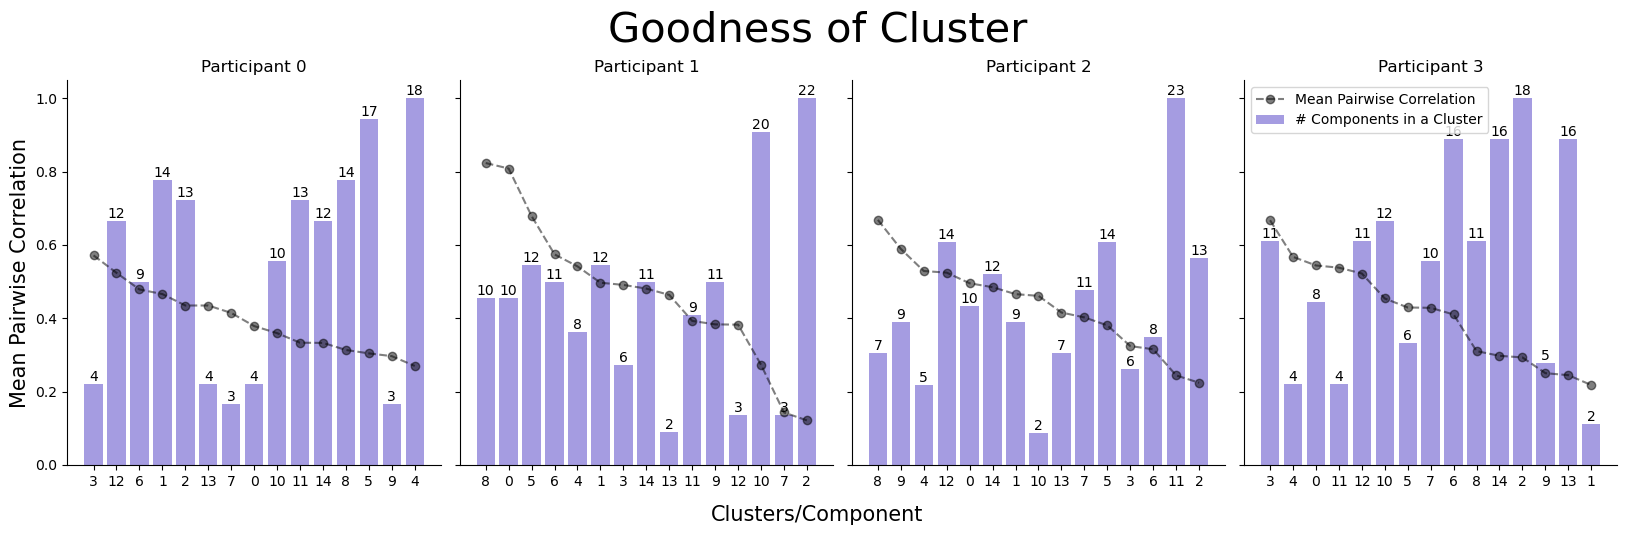

In [10]:
plot_internal_correlations(idk, [0,1,2,3])

In [11]:
nnls_0 = perform_plot_nnls(idk, 0, idk.X_dict[0], channel_plt=1, baseline_regressor=True, plot=False)
nnls_1 = perform_plot_nnls(idk, 1, idk.X_dict[1], channel_plt=1, baseline_regressor=True, plot=False)
nnls_2 = perform_plot_nnls(idk, 2, idk.X_dict[2], channel_plt=1, baseline_regressor=True, plot=False)
nnls_3 = perform_plot_nnls(idk, 3, idk.X_dict[3], channel_plt=1, baseline_regressor=True, plot=False)
nnls_all = [nnls_0, nnls_1, nnls_2, nnls_3]

In [1]:
# for participant in participant_list:
# participant = 3
# for comp in mean_correlation_sorted_indices_dict[participant][:5]:
#     pass
    # plot_combined_figure_1p(nnls_all, idk, participant, comp, image_dir, images_to_show=20, rows=5)
    # print_specific_component_images(idk, participant, comp, images_to_show = 40, rows = 2) 
    # plot_summarized_component(nnls_0[comp, :,:], participant, '')

In [13]:
# plot_results(idk, 0, plot = True, images_to_show=20, rows=2)


In [14]:
# print_specific_component_images(idk, 3, 3, images_to_show=15, rows=3)
# print_specific_component_images(idk, 3, 4, images_to_show=15, rows=3)
# print_specific_component_images(idk, 3, 0, images_to_show=15, rows=3)

### Finding common components across participants
Here we average data across channels and then check how components correlate across participants.

In [15]:
def make_corr_mat(a, b, n):
    '''
    ### Input
    a: np.array of shape (n, m)
    b: np.array of shape (n, m)
    n: number of components

    ### returns
    np.array of shape (n, n) with correlation coefficients between components of a and b
    '''                 
    corr_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            # print(f"correlation of {a[:,i].shape} and {j}")    
            corr_mat[i,j] = np.corrcoef(a[:,i], b[:,j])[0,1]
    return corr_mat

def max_corr_components(participant1, participant2):
    corr_matrix = make_corr_mat(idk.W_dict[participant1], idk.W_dict[participant2], nmf_components)
    plt.imshow(corr_matrix.T, cmap='plasma')
    plt.colorbar()  
    plt.title("Correlation Matrix of NMF Components")
    plt.xlabel("Participant 1")
    plt.ylabel("Participant 2")


    # Exclude diagonal (self-correlation) by setting it to NaN
    # np.fill_diagonal(corr_matrix, np.nan)

    # Get sorted indices of correlation values (flattened array)
    sorted_indices = np.argsort(-np.nan_to_num(corr_matrix).ravel())  # Negative for descending order

    # Convert back to 2D indices
    sorted_2d_indices = np.unravel_index(sorted_indices, corr_matrix.shape)

    # Stack row & col indices into tuples
    sorted_pairs = list(zip(sorted_2d_indices[0], sorted_2d_indices[1]))

    # Get top 10 correlated pairs
    max_corr_pairs = sorted_pairs[:20]

    # Ensure unique indices
    unique_pairs = []
    used_indices_p1 = set()  # Track already used indices participant 1
    used_indices_p2 = set()  # Track already used indices participant 2

    for pair in max_corr_pairs:
        if pair[0] not in used_indices_p1 and pair[1] not in used_indices_p2:
            unique_pairs.append(pair)
            used_indices_p1.add(pair[0])  # Use add() for single values
            used_indices_p2.add(pair[1])


    print([[unique_pair, corr_matrix[unique_pair[0], unique_pair[1]]] for unique_pair in unique_pairs])# Mark unique pairs in the correlation matrix   
    plt.plot([pair[0] for pair in unique_pairs], [pair[1] for pair in unique_pairs], 'o', markersize = 5, color = 'black')  
    # plt.plot([pair[1] for pair in unique_pairs], [pair[0] for pair in unique_pairs], 'ro')  
    plt.xlabel(f"Component Number (Participant {participant1})")
    plt.ylabel(f"Component Number (Participant {participant2})")
    plt.xticks(range(nmf_components))
    plt.yticks(range(nmf_components))
    plt.tight_layout()  
    plt.show()
    return unique_pairs, corr_matrix

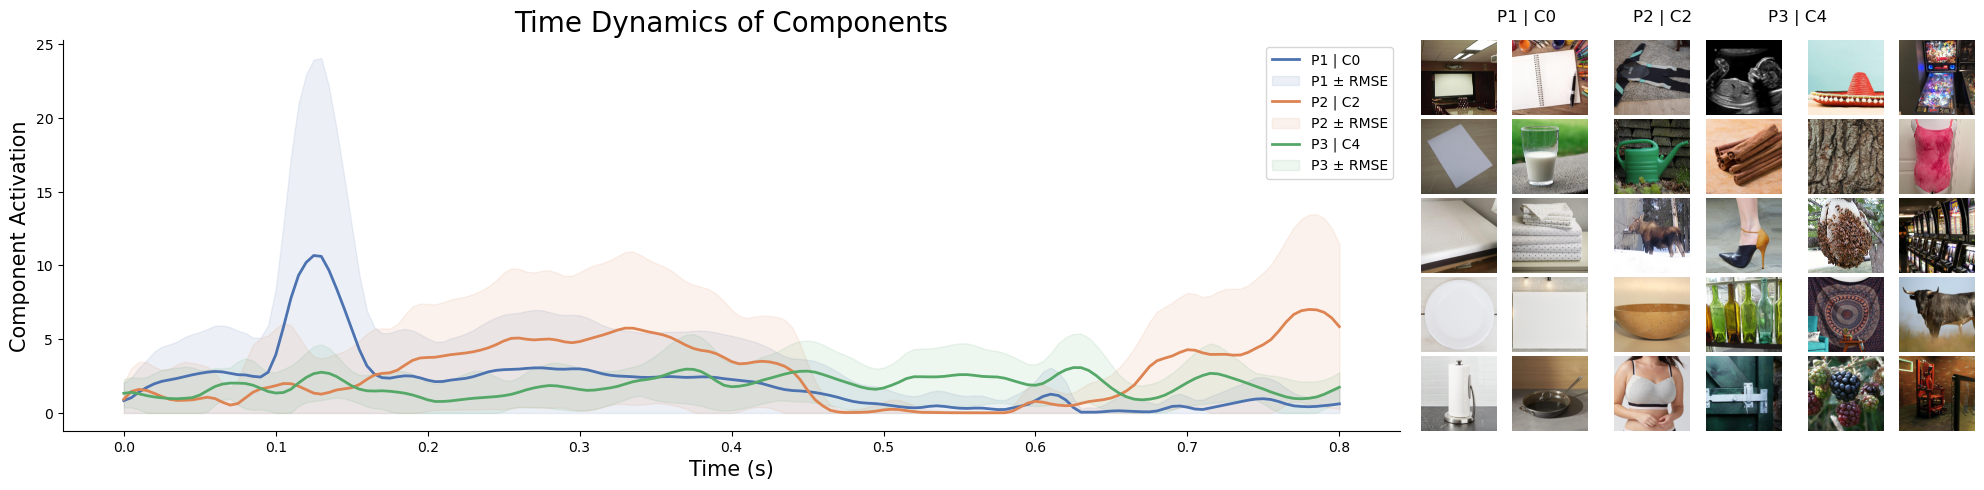

In [16]:
plot_combined_figure_np(nnls_all, idk, [1, 2,3], [0, 2, 4], image_dir)


In [17]:
# print_specific_component_images(idk, 1, 5, images_to_show=40, rows=4)   
# print_specific_component_images(idk, 2, 1, images_to_show=40, rows=4)

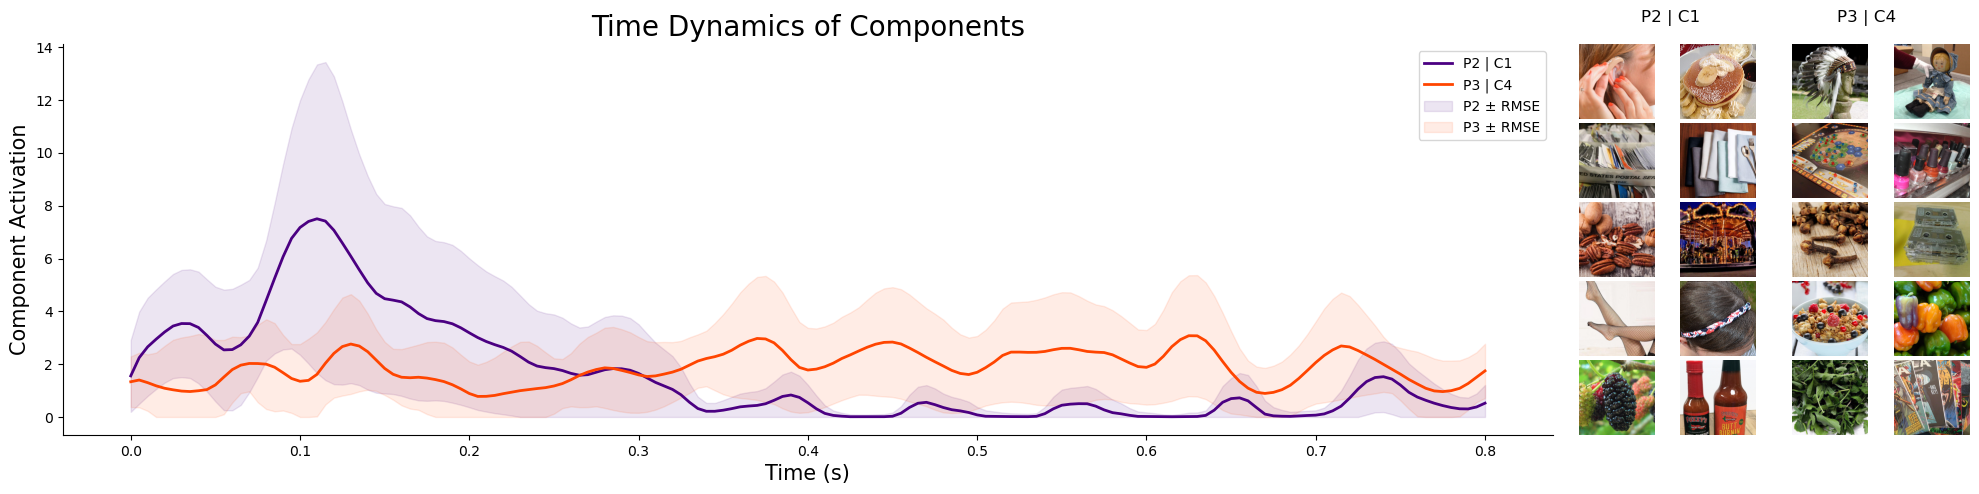

In [18]:
plot_combined_figure_2p(nnls_all, idk, [2, 3], [1, 4], image_dir, images_to_show=10, rows=5, shift = 10)

[[(5, 0), 0.2569071947698816], [(12, 4), 0.21962901552782468], [(4, 10), 0.21271842251029632], [(7, 11), 0.1871359699617519], [(1, 13), 0.1552457056190428], [(10, 12), 0.11621923018600992]]


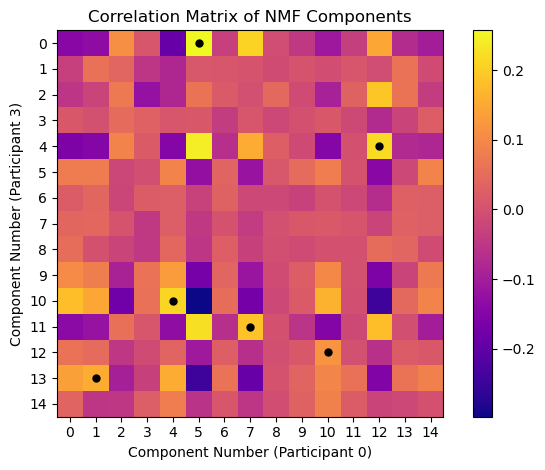

partcipant 0 component 5 and participant 3 component 0 correlation: 0.2569
partcipant 0 component 12 and participant 3 component 4 correlation: 0.2196
partcipant 0 component 4 and participant 3 component 10 correlation: 0.2127


In [19]:
p1 = 0
p2 = 3
unique_pairs, corr_matrix = max_corr_components(p1, p2)
for pair in unique_pairs[:3]:
    print(f"partcipant {p1} component {pair[0]} and participant {p2} component {pair[1]} correlation: {corr_matrix[pair[0], pair[1]]:.4f}")          
    # plot_combined_figure_2p(nnls_all, idk, [p1, p2], [pair[0], pair[1]], image_dir, images_to_show=10, rows=5, shift = 0)

[[(5, 5), 0.3621212263595201], [(4, 4), 0.28173404639938593], [(0, 0), 0.2705347029310711], [(7, 6), 0.22858617555604085], [(12, 9), 0.19031453858413944]]


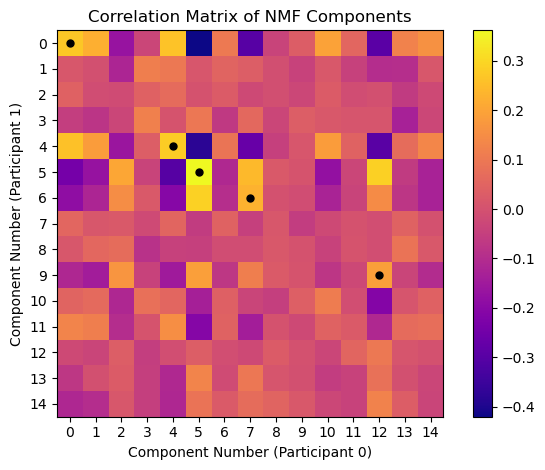

partcipant 0 component 5 and participant 1 component 5 correlation: 0.3621
partcipant 0 component 4 and participant 1 component 4 correlation: 0.2817
partcipant 0 component 0 and participant 1 component 0 correlation: 0.2705
[[(0, 0), 0.4720817733620224], [(4, 12), 0.4219814119694295], [(5, 1), 0.3762556797554834], [(9, 9), 0.34895519051422624], [(6, 3), 0.2792421643573147]]


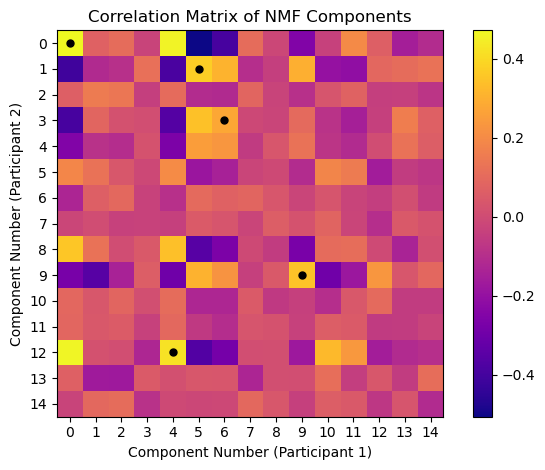

partcipant 1 component 0 and participant 2 component 0 correlation: 0.4721
partcipant 1 component 4 and participant 2 component 12 correlation: 0.4220
partcipant 1 component 5 and participant 2 component 1 correlation: 0.3763
[[(0, 10), 0.6178045571036863], [(5, 0), 0.4616157543058362], [(4, 13), 0.43518704049733864], [(6, 11), 0.3144021386750335], [(9, 2), 0.22297031132191789], [(1, 9), 0.21725158556597976]]


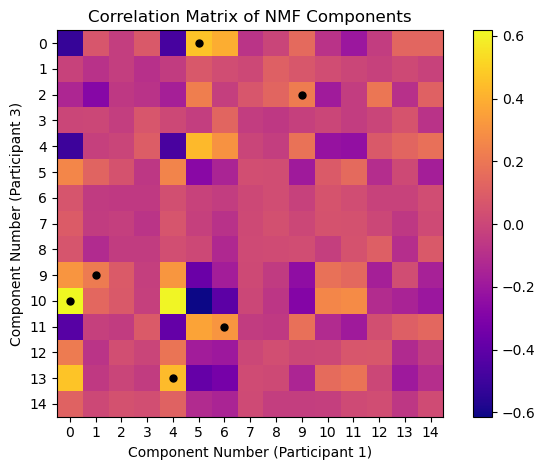

partcipant 1 component 0 and participant 3 component 10 correlation: 0.6178
partcipant 1 component 5 and participant 3 component 0 correlation: 0.4616
partcipant 1 component 4 and participant 3 component 13 correlation: 0.4352
[[(0, 10), 0.3383513638327386], [(1, 4), 0.2800124845493121], [(12, 13), 0.27853703873158986], [(3, 0), 0.2570977569666703], [(9, 2), 0.2143856317898518], [(8, 9), 0.171587400659399]]


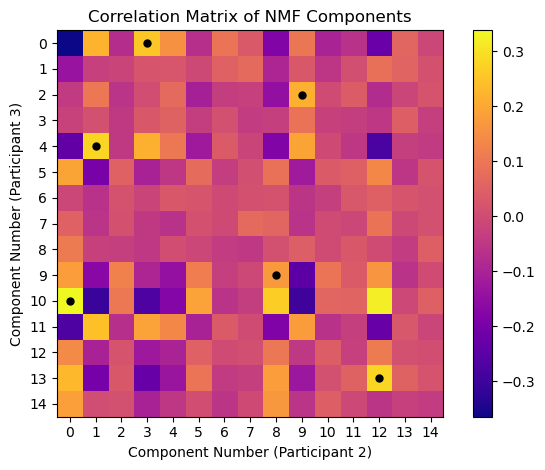

partcipant 2 component 0 and participant 3 component 10 correlation: 0.3384
partcipant 2 component 1 and participant 3 component 4 correlation: 0.2800
partcipant 2 component 12 and participant 3 component 13 correlation: 0.2785
[[(4, 0), 0.2518061597820696], [(5, 1), 0.24776257995227222], [(12, 9), 0.20717865919810113], [(1, 12), 0.18691435828320788], [(2, 4), 0.11493522236886212]]


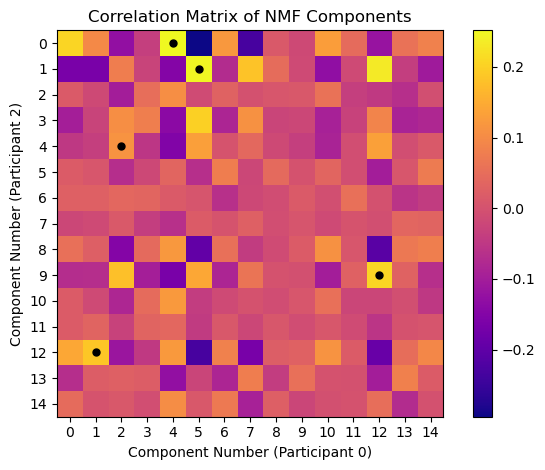

partcipant 0 component 4 and participant 2 component 0 correlation: 0.2518
partcipant 0 component 5 and participant 2 component 1 correlation: 0.2478
partcipant 0 component 12 and participant 2 component 9 correlation: 0.2072
[[(5, 0), 0.2569071947698816], [(12, 4), 0.21962901552782468], [(4, 10), 0.21271842251029632], [(7, 11), 0.1871359699617519], [(1, 13), 0.1552457056190428], [(10, 12), 0.11621923018600992]]


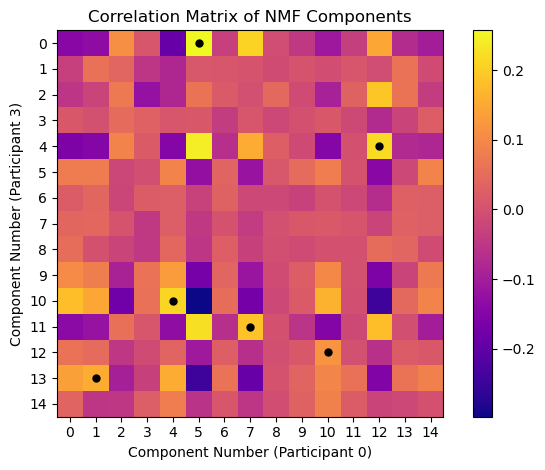

partcipant 0 component 5 and participant 3 component 0 correlation: 0.2569
partcipant 0 component 12 and participant 3 component 4 correlation: 0.2196
partcipant 0 component 4 and participant 3 component 10 correlation: 0.2127


In [20]:
p1 = 1
p2 = 3
pairs = [(0,1), (1,2), (1,3), (2,3), (0,2), (0,3)]     
for p1, p2 in pairs:
    unique_pairs, corr_matrix = max_corr_components(p1, p2)
    for pair in unique_pairs[:3]:
        print(f"partcipant {p1} component {pair[0]} and participant {p2} component {pair[1]} correlation: {corr_matrix[pair[0], pair[1]]:.4f}")          
        # plot_combined_figure_2p(nnls_all, idk, [p1, p2], [pair[0], pair[1]], image_dir)
        # print_specific_component_images(idk, p1, pair[0], images_to_show=20, rows = 2)  
        # print_specific_component_images(idk, p2, pair[1], images_to_show=20, rows = 2) 
        # plot_summarized_components(nnls_1[pair[0],:,:], nnls_2[pair[1],:,:], participants = [p1, p2], title = f"NNLS P{p1} Comp {pair[0]} and P{p2} Comp {pair[1]}")            
        # plot_combined_figure_2p(nnls_all, idk, [p1, p2], [pair[0], pair[1]], image_dir, images_to_show=10, rows=5)
        # temp1 = idk.H_dict[p1].reshape(nmf_components, idk.NOS_CHANNELS_OPT, idk.NOS_TIME_POINTS)
        # temp2 = idk.H_dict[p2].reshape(nmf_components, idk.NOS_CHANNELS_OPT, idk.NOS_TIME_POINTS)
        # temp1 = temp1 - temp1.min()
        # temp2 = temp2 - temp2.min()     
        # Compute the correlation matrix across all channels for each component to give 10 subplots of imshow
        # plt.figure(figsize=(15, 5))
        # plt.plot(idk.time_points_new, temp1[pair[0], 20:, :].T, alpha = 0.1)
        # plt.plot(idk.time_points_new, temp1[pair[0], 20:, :].mean(axis=0), color = 'red', lw = 2, label = f"Participant {p1} Component {pair[0]}")
        # plt.plot(idk.time_points_new, temp2[pair[1], 20:, :].T, alpha = 0.1)
        # plt.plot(idk.time_points_new, temp2[pair[1], 20:, :].mean(axis=0), color = 'blue', lw = 2, label = f"Participant {p2} Component {pair[1]}")
        # plt.show()
        # plot_summarized_components(temp1[pair[0]], temp2[pair[1]], dim = 2, title = f"H matrix NMF P{p1} Comp {pair[0]} and P{p2} Comp {pair[1]}")   

In [21]:
raise SystemError("STOP")

SystemError: STOP

### trials

Component 0 is best loaded by the following image categories:


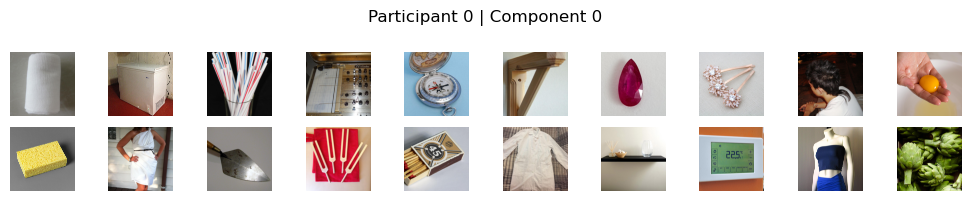

In [ ]:
print_specific_component_images(idk, 0, 0, images_to_show=20, rows=2)

In [ ]:
# temp1 = idk.H_dict[1].reshape(nmf_components, idk.NOS_CHANNELS_OPT, idk.NOS_TIME_POINTS)
# temp2 = idk.H_dict[2].reshape(nmf_components, idk.NOS_CHANNELS_OPT, idk.NOS_TIME_POINTS)
# # Compute the correlation matrix across all channels for each component to give 10 subplots of imshow
# plt.subplots(2, 5, figsize=(15, 6))
# plt.suptitle("Corr of components for Parti 1 and 2 (H matrix)")   
# for i in range(nmf_components):
#     corr_mat = make_corr_mat(temp1[i,:,:], temp2[i,:,:], idk.NOS_CHANNELS_OPT)
#     plt.subplot(2, 5, i+1)
#     plt.imshow(corr_mat, cmap='viridis')    
#     plt.xlabel(f"Component {i}")
# plt.tight_layout()       
# plt.colorbar()  
# plt.show()  

In [ ]:
nnls_1 = perform_plot_nnls(idk, p1, idk.X_dict[p1], channel_plt=1, baseline_regressor=True)
nnls_2 = perform_plot_nnls(idk, p2, idk.X_dict[p2], channel_plt=1, baseline_regressor=True)

In [ ]:
nnls_1.shape

(16, 39, 161)

In [ ]:
for 
plot_summarized_components(nnls_1[pair[0],:,:], nnls_2[pair[1],:,:], dim = 2, title = f"NNLS P{p1} Comp {pair[0]} and P{p2} Comp {pair[1]}")            

SyntaxError: invalid syntax (1564825128.py, line 1)

In [ ]:
print([[unique_pair, corr_matrix[unique_pair[0], unique_pair[1]]] for unique_pair in unique_pairs])# Mark unique pairs in the correlation matrix 

In [ ]:
channel_corr_nnls = np.zeros((nmf_components + 1, idk.NOS_CHANNELS_OPT, idk.NOS_CHANNELS_OPT))  
for i in range(11):
    for j in range(39):
        for k in range(39):
            channel_corr_nnls[i,j,k] = np.corrcoef(nnls_1[i,j,:], nnls_3[i,k,:])[0,1]

In [ ]:
# plot 16 plots of correlation between channels for each component
plt.subplots(4, 4, figsize=(15, 15))            
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(channel_corr_nnls[i,:,:], cmap='viridis')    
    plt.xlabel(f"Component {i}")
plt.tight_layout()
plt.colorbar()
plt.show()


We see a lot of variation across channels, so we try to do PCA/NMF and see if one component can be summarized by new components in PCA/NMF which explains the highest variance. 

In [ ]:
# plt.figure(figsize=(20, 5))
# plt.title("PCA max component for participant 1 (on NNLS)")
# print("Participant 1 explained variance ratio")
# for i in range(nmf_components):
#     pca = PCA(n_components=1)
#     a = pca.fit_transform(nnls_1[i,:,:].T) 
#     print(f"Component {i} explained variance ratio: {pca.explained_variance_ratio_[0]}")   
#     plt.plot(a, label = f'Component {i}')
# plt.ylabel("Amplitude")
# plt.xlabel("Time points")   
# plt.legend()
# plt.show()

# plt.figure(figsize=(20, 5))
# plt.title("PCA max component for participant 2 (on NNLS)")
# print("Participant 2")
# for i in range(nmf_components):
#     pca = PCA(n_components=1)
#     a = pca.fit_transform(nnls_2[i,:,:].T) 
#     print(f"Component {i} explained variance ratio: {pca.explained_variance_ratio_[0]}")   
#     plt.plot(a, label = f'Component {i}')
# plt.legend()
# plt.ylabel("Amplitude")
# plt.xlabel("Time (ms)") 
# plt.show()

# pca = PCA(n_components=1)
# a = pca.fit_transform(nnls_1[1,:,:].T)
# a.shape
# plt.plot(a)

PCA does okayish job.

We try NMF over channels now!

In [ ]:
# doing NMF on the nnls results 
# summary_components_1 = np.zeros((nmf_components, NOS_TIME_POINTS))
summary_components_1 = np.zeros((nmf_components, 161))
plt.figure(figsize=(20, 5)) 
print(nnls_1[0,:,:].shape)
for i in range(nmf_components): 
    nmf = NMF(n_components=1, init='random', max_iter=200, random_state= 42)
    X = nnls_1[i,:,:]
    W = nmf.fit_transform(X)
    H = nmf.components_
    # plt.plot(idk.time_points_new, H.T, label = f'Component {i}')
    plt.plot(H.T, label = f'Component {i}')
    summary_components_1[i,:] = H
    # print(i, compute_evar_all(nnls_1[i,:,:], W, H))
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("NMF components for participant 1 on NNLS results")   
plt.legend()
plt.show()

In [ ]:
# doing NMF on the nnls results 
# summary_components_2 = np.zeros((nmf_components, NOS_TIME_POINTS))  
summary_components_2 = np.zeros((nmf_components, 161)) 
plt.figure(figsize=(20, 5))
print(nnls_1[0,:,:].shape)
for i in range(nmf_components):
    nmf = NMF(n_components=1, init='random', max_iter=200, random_state= 42)
    X = nnls_2[i,:,:]
    W = nmf.fit_transform(X)
    H = nmf.components_
    # plt.plot(idk.time_points_new, H.T, label = f'Component {i}')
    plt.plot(H.T, label = f'Component {i}')
    summary_components_2[i,:] = H
    # print(i, compute_evar_all(nnls_2[i,:,:], W, H))
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("NMF components for participant 2 on NNLS results")
plt.legend()
plt.show()

In [ ]:
# doing NMF on the nnls results 
summary_components_3 = np.zeros((nmf_components, idk.NOS_TIME_POINTS))  
plt.figure(figsize=(20, 5))
print(nnls_3[0,:,:].shape)
for i in range(nmf_components):
    nmf = NMF(n_components=1, init='random', max_iter=200, random_state= 42)
    X = nnls_3[i,:,:]
    W = nmf.fit_transform(X)
    H = nmf.components_
    plt.plot(idk.time_points_new, H.T, label = f'Component {i}')
    summary_components_3[i,:] = H
    # print(i, compute_evar_all(nnls_2[i,:,:], W, H))
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("NMF components for participant 2 on NNLS results")
plt.legend()
plt.show()

NMF does amazing job at summarizing each component across all channels.\
Now that we have better ways to summarize data across channels than just averaging it, we calculate the cross correlation across participants again. 

In [ ]:
# plot summary components of unique pairs
for pair in unique_pairs[:]:
    print(f"partcipant 1 component {pair[0]} and participant 2 component {pair[1]} correlation: {corr_matrix[pair[0], pair[1]]:.4f}")   
    plt.figure(figsize=(10, 2))        
    plt.plot(idk.time_points_new, summary_components_1[pair[0],:], label = f'Participant 1 Component {pair[0]}')
    plt.plot(idk.time_points_new, summary_components_2[pair[1],:], label = f'Participant 2 Component {pair[1]}')
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude")
    plt.title(f"Comparison of Components {pair[0]} and {pair[1]} | Cat corr: {corr_matrix[pair[0], pair[1]]:.4f} | NNLS corr {np.corrcoef(summary_components_1[pair[0],:], summary_components_2[pair[1],:])[0,1]:.4f}")     
    plt.legend()
    plt.show()  
    # idk.print_specific_component_images(1, pair[0])
    # idk.print_specific_component_images(2, pair[1])

In [ ]:
raise SystemExit("Stop right there!")   

In [ ]:

# Compute correlation matrix
corr_matrix = make_corr_mat(summary_components_1, summary_components_2, idk.new_nmf_components)
plt.imshow(corr_matrix.T, cmap='viridis')  
plt.colorbar()  
plt.title("Correlation Matrix of summarized NMF Components")
# Exclude diagonal (self-correlation) by setting it to NaN
# np.fill_diagonal(corr_matrix, np.nan)

# Get sorted indices of correlation values (flattened array)
sorted_indices = np.argsort(-np.nan_to_num(corr_matrix).ravel())  # Negative for descending order

# Convert back to 2D indices
sorted_2d_indices = np.unravel_index(sorted_indices, corr_matrix.shape)

# Stack row & col indices into tuples
sorted_pairs = list(zip(sorted_2d_indices[0], sorted_2d_indices[1]))

# Get top 10 correlated pairs
max_corr_pairs = sorted_pairs[:60]

# Ensure unique indices
unique_pairs = []
used_indices_p1 = set()  # Track already used indices participant 1
used_indices_p2 = set()  # Track already used indices participant 2

for pair in max_corr_pairs:
    if pair[0] not in used_indices_p1 and pair[1] not in used_indices_p2:
        unique_pairs.append(pair)
        used_indices_p1.add(pair[0])  # Use add() for single values
        used_indices_p2.add(pair[1])


print([[unique_pair, corr_matrix[unique_pair[0], unique_pair[1]]] for unique_pair in unique_pairs])# Mark unique pairs in the correlation matrix   
# plt.plot([pair[0] for pair in unique_pairs], [pair[1] for pair in unique_pairs], 'ro')  
plt.plot([pair[0] for pair in unique_pairs], [pair[1] for pair in unique_pairs], 'ro')  
plt.xlabel("Component Number (Participant 1)")
plt.ylabel("Component Number (Participant 2)")
plt.xticks(range(idk.new_nmf_components))
plt.yticks(range(idk.new_nmf_components))
plt.show()
len(unique_pairs)

In [ ]:
# subplot for first 4 pair of component with highest correlation
fig, axs = plt.subplots(10, 1, figsize=(7, 15)) 
for i, pair in enumerate(unique_pairs[:]):
    axs[i].plot(summary_components_1[pair[0],:], label='Participant 1')
    axs[i].plot(summary_components_2[pair[1],:], label='Participant 2')
    axs[i].set_title(f"Comparison of NMF Components {pair[0]} and {pair[1]} with corr: {corr_matrix[pair[0], pair[1]]:.4f}")    
    axs[i].set_xlabel("Time (ms)")
    axs[i].set_ylabel("Amplitude")
    # axs[i].legend()
plt.tight_layout()
plt.show()

Plot images with high correlations
Uncomment and run the code below

In [ ]:
# show the images for the top 5 categories for the first 4 components with highest correlation
# for pair in unique_pairs[:]:
#     print(f"partcipant 1 component {pair[0]} and participant 2 component {pair[1]} correlation: {corr_matrix[pair[0], pair[1]]:.4f}")          
#     idk.print_specific_component_images(1, pair[0])
#     idk.print_specific_component_images(2, pair[1])

In [ ]:
# # plot all the components for participant 1 and 2
# idk.plot_results(1, True)
# idk.plot_results(2, True)

In [ ]:
# # print category names for each component horizontally 
# # # save dictionary to csv
# # idk.category_array_name_dict[]
# df = pd.DataFrame.from_dict(idk.category_array_name_dict[1])
# df.to_csv('category_array_name_dict_1.csv')
# df = pd.DataFrame.from_dict(idk.category_array_name_dict[2])
# df.to_csv('category_array_name_dict_2.csv')


In [ ]:
raise SystemExit("End of working code")

In [ ]:
# # Extract the time points in the given range
# time_points_2 = idk.time_points[(idk.time_points >= time_window[0]) & (idk.time_points <= time_window[1])]

# # Define time window in seconds
# time_window_2 = [0.0, 0.8]  # in seconds

# # Extract the NNLS coefficients for the selected time range
# array = idk.nnls_results[2][:, :, (time_points_2 >= time_window_2[0]) & (time_points_2 <= time_window_2[1])]

# # Set up the figure for 11 subplots (arranged in a grid)
# fig, axes = plt.subplots(3, 4, figsize=(15, 12))  # 3 rows, 4 columns (extra space for 11th plot)
# plt.suptitle(f"NNLS Coefficients for Time Window {time_window_2[0]} to {time_window_2[1]} s", fontsize=16)  
# # Loop over components and plot their correlation matrix
# for component in range(nmf_components):
#     corr_matrix = np.zeros((39, 39))
#     for i in range(39):
#         for j in range(39):
#             corr_matrix[i, j] = np.corrcoef(array[component, i, :].flatten(), array[component, j, :].flatten())[0, 1]
    
#     # Get subplot index
#     ax = axes.flatten()[component]
    
#     # Display the correlation matrix
#     im = ax.imshow(corr_matrix, cmap="viridis", aspect="auto")
#     ax.set_title(f"Component {component}")
#     ax.set_xticks([])
#     ax.set_yticks([])
    
#     # Add colorbar only to the rightmost column
#     if component % 4 == 3 or component == nmf_components - 1:
#         fig.colorbar(im, ax=ax)

# # Hide the last subplot if nmf_components < 12
# for i in range(nmf_components, 12):
#     fig.delaxes(axes.flatten()[i])

# plt.tight_layout()
# plt.show()

In [ ]:
NOS_CHANNELS_OPT = 39
NOS_TIME_POINTS = 161


W = idk.W_dict[2]
X = idk.X_dict[2]
X_scaled = X.reshape(NOS_CONCEPTS, NOS_CHANNELS_OPT, NOS_TIME_POINTS)
X_scaled = X_scaled / X_scaled.max(axis=0)
# adding baseline regressor to W 
print(W.shape)  
W = W.T  # Now W is (10, 1854)
W = np.vstack([W, np.ones((1, W.shape[1]))]).T  # Now W is (11, 1854)
print(W.shape)
nnls_results = np.zeros((nmf_components + 1 , NOS_CHANNELS_OPT, NOS_TIME_POINTS))    
for channel in range(NOS_CHANNELS_OPT):
    for t in range(NOS_TIME_POINTS):
        nnls_results[:, channel, t] = nnls(W, X_scaled[:,channel,t])[0]
# --- Example Plot ---
# Plot the NNLS coefficient time series for channel 0 for all components.
time_points = np.arange(self.NOS_TIME_POINTS)
plt.figure(figsize=(20, 5))
for comp in range(nmf_components):
    plt.plot(time_points, nnls_results[comp, 0, :], alpha=0.7, label=f"Component {comp}")
plt.title("NNLS Coefficients Over Time for Channel 0 (Locally Scaled)")
plt.xlabel("Time (ms)")
plt.ylabel("Coefficient (scaled)")
plt.legend()
plt.show()
self.nnls_results[participant_no] = nnls_results
# return nnls_results

In [ ]:
plt.figure(figsize=(20, 5)) 
plt.plot(idk.nnls_results[2][:,0,:].sum(axis = 0))    
plt.show()

In [ ]:
idk.nnls_results[0].shape, idk.nnls_results[2].shape

In [ ]:
# find correlation between nnls results (10 x 10 correlation matrix)
correlation_matrix = np.zeros((nmf_components, nmf_components))
for i in range(nmf_components):
    for j in range(nmf_components):
        correlation_matrix[i,j] = np.corrcoef(idk.nnls_results[0][i].flatten(), idk.nnls_results[2][j].flatten())[0,1]

In [ ]:
# plot correlation matrix
plt.imshow(correlation_matrix, cmap='viridis')
plt.colorbar()
plt.title("Correlation Matrix of NNLS Coefficients")
plt.xlabel("Participant 2")
plt.ylabel("Participant 0")
plt.show()

In [ ]:
raise ValueError("Stop here")